Load the dataset

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow_datasets as tfds


2022-12-09 20:10:16.450971: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/andyliang/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import csv
import os

datapath = 'clothing-dataset/'
data = []
with open(os.path.join(datapath, 'images.csv')) as csv_file:
    reader = csv.reader(csv_file, delimiter=',')
    for line in reader:
        data.append(line)
    

In [3]:
print(data[:10])

[['image', 'sender_id', 'label', 'kids'], ['4285fab0-751a-4b74-8e9b-43af05deee22', '124', 'Not sure', 'False'], ['ea7b6656-3f84-4eb3-9099-23e623fc1018', '148', 'T-Shirt', 'False'], ['00627a3f-0477-401c-95eb-92642cbe078d', '94', 'Not sure', 'False'], ['ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa', '43', 'T-Shirt', 'False'], ['3b86d877-2b9e-4c8b-a6a2-1d87513309d0', '189', 'Shoes', 'False'], ['5d3a1404-697f-479f-9090-c1ecd0413d27', '138', 'Shorts', 'False'], ['b0c03127-9dfb-4573-8934-1958396937bf', '138', 'Shirt', 'False'], ['4c8f245e-a039-46fd-a6b9-1bb51e83fc05', '226', 'T-Shirt', 'False'], ['c995c900-693d-4dd6-8995-43f3051ec488', '337', 'Pants', 'False']]


In [4]:
labels = data[0]
data = data[1:]

In [5]:
print(labels)
print(data[:10])

['image', 'sender_id', 'label', 'kids']
[['4285fab0-751a-4b74-8e9b-43af05deee22', '124', 'Not sure', 'False'], ['ea7b6656-3f84-4eb3-9099-23e623fc1018', '148', 'T-Shirt', 'False'], ['00627a3f-0477-401c-95eb-92642cbe078d', '94', 'Not sure', 'False'], ['ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa', '43', 'T-Shirt', 'False'], ['3b86d877-2b9e-4c8b-a6a2-1d87513309d0', '189', 'Shoes', 'False'], ['5d3a1404-697f-479f-9090-c1ecd0413d27', '138', 'Shorts', 'False'], ['b0c03127-9dfb-4573-8934-1958396937bf', '138', 'Shirt', 'False'], ['4c8f245e-a039-46fd-a6b9-1bb51e83fc05', '226', 'T-Shirt', 'False'], ['c995c900-693d-4dd6-8995-43f3051ec488', '337', 'Pants', 'False'], ['bf78527f-0734-44fd-a968-f6c32c12d61e', '175', 'Shoes', 'False']]


In [6]:
num_examples = len(data)
print(len(data))

5403


In [20]:
label_counts = dict()
for row in data:
    if row[2] not in label_counts:
        label_counts[row[2]] = 0
    label_counts[row[2]] += 1
    
valid_labels = dict()
for k, v in label_counts.items():
    if v >= 100 and k not in ['Not sure', 'Others', 'Skip']:
        valid_labels[k] = v

filename_to_label = dict()
cleaned_data = []
valid_filenames = []
for i in range(len(data)):
    if data[i][2] in valid_labels.keys():
        cleaned_data.append(data[i])
        valid_filenames.append(data[i][0])
        filename_to_label[data[i][0]] = data[i][2]



num_examples = len(cleaned_data)
print(num_examples)

4961


In [21]:
import os
import shutil

imagespath = 'clothing-dataset/images'
images = [f for f in os.listdir(imagespath) if os.path.isfile(os.path.join(imagespath, f))]

num_images_moved = 0



for i in range(len(images)):
    filename = images[i].split(".")[0]
    if filename not in valid_filenames:
        continue
        
    if num_images_moved < num_train + num_validate:
        folder_name = 'train'
    else:
        folder_name = 'test'
    
    new_folder = os.path.join(imagespath, folder_name)
    
    classname = filename_to_label[filename]
    finalfoldername = os.path.join(new_folder, classname)
    
    if not os.path.exists(finalfoldername):
        os.makedirs(finalfoldername)
    
    old_image_path = os.path.join(imagespath, images[i])
    new_image_path = os.path.join(finalfoldername, images[i])
    shutil.move(old_image_path, new_image_path)
    num_images_moved += 1

In [22]:
num_train = 3600
num_validate = 900
num_test = 461
epochs = 50
batch_size = 16
train_dir = os.path.join(os.getcwd(), os.path.join(imagespath, 'train'))
img_height = 128
img_width = 128
input_shape = (128, 128, 3)
num_classes = len(valid_labels)
labels = ["Blazer", 'Dress', 'Hat', 'Hoodie', 'Longsleeve', 'Outwear', 'Pants', 'Polo', 'Shirt', 'Shoes', 'Shorts', 'Skirt', 'T-Shirt', 'Undershirt']
print(num_classes)

14


In [23]:
import random
seed = random.randint(1, 10000)
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_dir = os.path.join(os.getcwd(), os.path.join(imagespath, 'test'))
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 14 classes.
Using 3600 files for training.
Found 4500 files belonging to 14 classes.
Using 900 files for validation.
Found 461 files belonging to 14 classes.


In [ ]:
lmao = train_ds.take(1)
fig, ax = plt.subplots(3, 3)
for x, y in tfds.as_numpy(lmao):
    for i in range(batch_size):
        if i < 9:
            ax[i // 3, i % 3].imshow(x[i] / 255)
            ax[i // 3, i % 3].set_title(labels[y[i]])
            ax[i // 3, i % 3].axis('off')

In [24]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal_and_vertical"), 
                                         tf.keras.layers.RandomRotation(0.2),])
model = tf.keras.Sequential([
    data_augmentation, 
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [25]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [26]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
225/225 [==============================] - 14s 54ms/step - loss: 2.4337 - accuracy: 0.2131 - val_loss: 2.3480 - val_accuracy: 0.1789
Epoch 2/50
225/225 [==============================] - 12s 55ms/step - loss: 2.2361 - accuracy: 0.2769 - val_loss: 2.3206 - val_accuracy: 0.2333
Epoch 3/50
225/225 [==============================] - 13s 56ms/step - loss: 2.0962 - accuracy: 0.3325 - val_loss: 2.3656 - val_accuracy: 0.2200
Epoch 4/50
225/225 [==============================] - 13s 56ms/step - loss: 1.9920 - accuracy: 0.3742 - val_loss: 2.4072 - val_accuracy: 0.2089
Epoch 5/50
225/225 [==============================] - 13s 56ms/step - loss: 1.8867 - accuracy: 0.4106 - val_loss: 2.4224 - val_accuracy: 0.2789
Epoch 6/50
225/225 [==============================] - 13s 56ms/step - loss: 1.8137 - accuracy: 0.4350 - val_loss: 2.4865 - val_accuracy: 0.2467
Epoch 7/50
225/225 [==============================] - 13s 57ms/step - loss: 1.7424 - accuracy: 0.4511 - val_loss: 2.5083 - val_accuracy:

29/29 [==============================] - 1s 15ms/step - loss: 5.0885 - accuracy: 0.2495
Accuracy: 24.94577020406723%


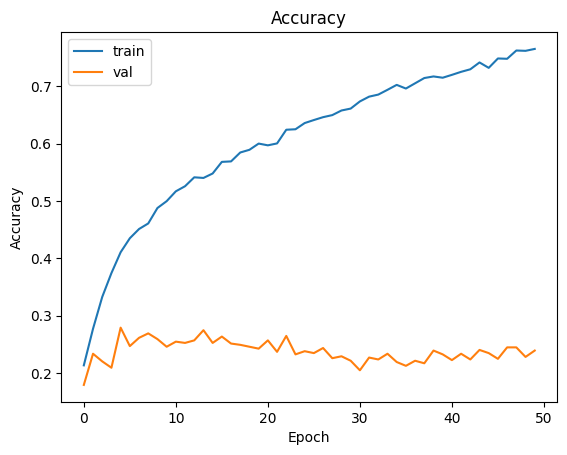

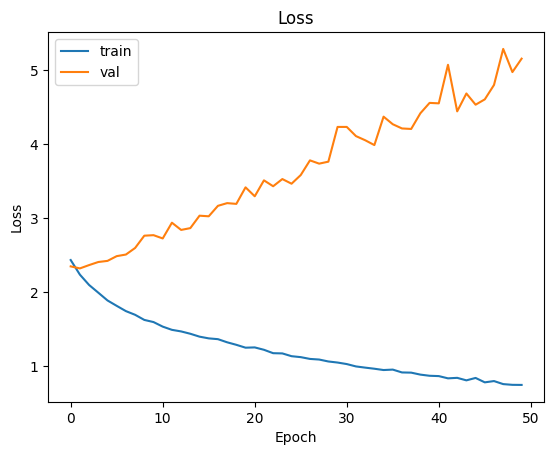

In [27]:
predictor = tf.keras.Sequential([
    model,
    tf.keras.layers.Softmax()
])
predictor.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])
accuracy = predictor.evaluate(test_ds)[1]
print(f"Accuracy: {accuracy * 100}%")

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'val'], loc='upper left')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'val'], loc='upper left')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [16]:
transfer_model = tf.keras.Sequential()
resnet50 = tf.keras.applications.ResNet50V2(include_top=False,
                    input_shape=(img_height,img_width,3),
                    pooling='avg',classes=num_classes,
                    weights='imagenet')

#transfer_model.add(data_augmentation)

for layer in resnet50.layers:
    layer.trainable = False

transfer_model.add(resnet50)
transfer_model.add(Flatten())
transfer_model.add(tf.keras.layers.BatchNormalization())
transfer_model.add(Dense(128, activation='relu'))
transfer_model.add(Dropout(0.1))
transfer_model.add(tf.keras.layers.BatchNormalization())
transfer_model.add(Dense(num_classes))


In [17]:

transfer_model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
history = transfer_model.fit(train_ds, validation_data=val_ds, epochs=epochs)


Epoch 1/50
225/225 [==============================] - 57s 245ms/step - loss: 2.2629 - accuracy: 0.3231 - val_loss: 1.9646 - val_accuracy: 0.4178
Epoch 2/50
225/225 [==============================] - 54s 241ms/step - loss: 1.6803 - accuracy: 0.4769 - val_loss: 1.8182 - val_accuracy: 0.4544
Epoch 3/50
225/225 [==============================] - 54s 242ms/step - loss: 1.4682 - accuracy: 0.5306 - val_loss: 1.8473 - val_accuracy: 0.4444
Epoch 4/50
225/225 [==============================] - 54s 240ms/step - loss: 1.2981 - accuracy: 0.5850 - val_loss: 1.8546 - val_accuracy: 0.4678
Epoch 5/50
225/225 [==============================] - 55s 243ms/step - loss: 1.1615 - accuracy: 0.6186 - val_loss: 1.8785 - val_accuracy: 0.4811
Epoch 6/50
225/225 [==============================] - 54s 242ms/step - loss: 1.0589 - accuracy: 0.6625 - val_loss: 2.0439 - val_accuracy: 0.4667
Epoch 7/50
225/225 [==============================] - 55s 244ms/step - loss: 0.9512 - accuracy: 0.6986 - val_loss: 2.1055 - val_ac

29/29 [==============================] - 6s 191ms/step - loss: 5.2743 - accuracy: 0.5033
Accuracy: 50.32538175582886%


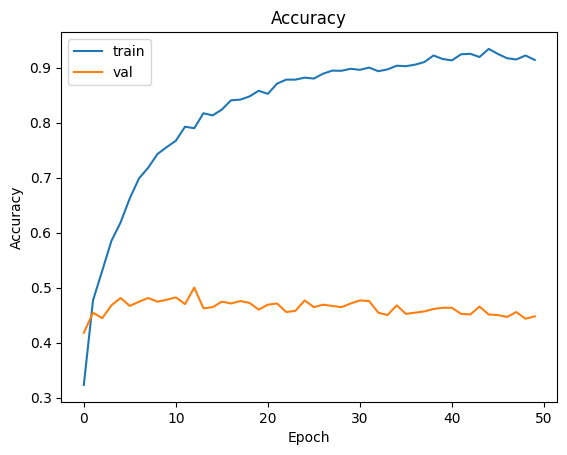

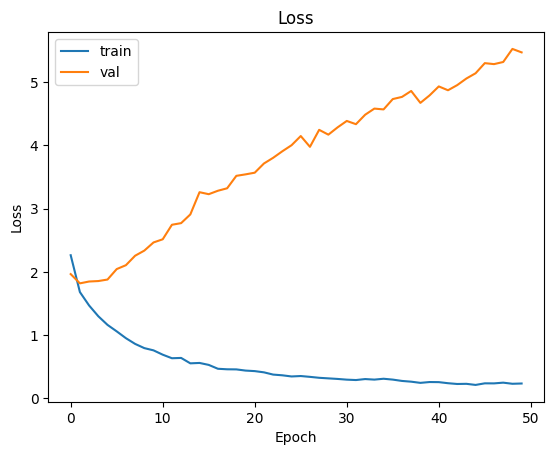

In [19]:

accuracy = transfer_model.evaluate(test_ds)[1]
print(f"Accuracy: {accuracy * 100}%")

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'val'], loc='upper left')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'val'], loc='upper left')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [128]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [130]:
num_classes = 14
input_shape = (128, 128, 3)

learning_rate = 0.001
batch_size = 265
hidden_units = 512
projection_units = 128
num_epochs = 50
dropout_rate = 0.5
temperature = 0.05


import random
seed = random.randint(1, 10000)
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_dir = os.path.join(os.getcwd(), os.path.join(imagespath, 'test'))
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 14 classes.
Using 3600 files for training.
Found 4500 files belonging to 14 classes.
Using 900 files for validation.


In [131]:
def encoder():
    transfer_model = keras.applications.ResNet50V2(
        include_top=False, weights=None, input_shape=input_shape, pooling="avg"
    )

    inputs = keras.Input(shape=input_shape)
    outputs = transfer_model(inputs)
    final_encoder = keras.Model(inputs=inputs, outputs=outputs)
    return final_encoder


initial_encoder = encoder()
initial_encoder.summary()


Model: "cifar10-encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_41 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
Total params: 23,564,800
Trainable params: 23,519,360
Non-trainable params: 45,440
_________________________________________________________________


In [132]:
def classifier(initial_encoder, trainable=True):

    for layer in initial_encoder.layers:
        layer.trainable = trainable

    inputs = keras.Input(shape=input_shape)
    learned_features = initial_encoder(inputs)
    learned_features = layers.Dropout(dropout_rate)(learned_features)
    learned_features = layers.Dense(hidden_units, activation="relu")(learned_features)
    learned_features = layers.Dropout(dropout_rate)(learned_features)
    outputs = layers.Dense(num_classes, activation="softmax")(learned_features)

    final_model = keras.Model(inputs=inputs, outputs=outputs)
    final_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )
    return final_model

In [133]:
class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        normalized_feature_vectors = tf.math.l2_normalize(feature_vectors, axis=1)
        calculated_logits = tf.divide(tf.matmul(normalized_feature_vectors, tf.transpose(normalized_feature_vectors)), self.temperature)
        return tfa.losses.npairs_loss(tf.squeeze(labels), calculated_logits)


def projection(initial_encoder):
    inputs = keras.Input(shape=input_shape)
    learned_features = initial_encoder(inputs)
    outputs = layers.Dense(projection_units, activation="relu")(learned_features)
    final_model = keras.Model(inputs=inputs, outputs=outputs)
    return final_model

In [135]:
initial_encoder = encoder()

encoder_projection = projection(initial_encoder)
encoder_projection.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=SupervisedContrastiveLoss(temperature),
)

encoder_projection.summary()

history = encoder_projection.fit(
    train_ds, batch_size=batch_size, epochs=num_epochs
)

Model: "cifar-encoder_with_projection-head"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_47 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 cifar10-encoder (Functional  (None, 2048)             23564800  
 )                                                               
                                                                 
 dense_50 (Dense)            (None, 128)               262272    
                                                                 
Total params: 23,827,072
Trainable params: 23,781,632
Non-trainable params: 45,440
_________________________________________________________________
Epoch 1/50
225/225 [==============================] - 190s 831ms/step - loss: 2.3267
Epoch 2/50
 57/225 [======>.......................] - ETA: 2:20 - loss: 2.1956

KeyboardInterrupt: 

In [ ]:
accuracy = encoderprojection.evaluate(test_ds)[1]
print(f"Accuracy: {accuracy * 100}%")

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'val'], loc='upper left')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'val'], loc='upper left')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()